In [1]:
%matplotlib ipympl
import mido
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

In [2]:
filename = "KCP Major 1.mid"
m = mido.MidiFile(filename=filename)
print(m.print_tracks())

=== Track 0
MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0)
MetaMessage('set_tempo', tempo=315789, time=0)
MetaMessage('key_signature', key='C', time=0)
MetaMessage('end_of_track', time=0)
=== Track 1
MetaMessage('track_name', name='harmony:Piano Full Voicing', time=0)
Message('note_on', channel=0, note=48, velocity=71, time=0)
Message('note_on', channel=0, note=55, velocity=71, time=0)
Message('note_on', channel=0, note=60, velocity=71, time=0)
Message('note_on', channel=0, note=64, velocity=71, time=0)
Message('note_off', channel=0, note=48, velocity=90, time=4094)
Message('note_off', channel=0, note=55, velocity=90, time=0)
Message('note_off', channel=0, note=60, velocity=90, time=0)
Message('note_off', channel=0, note=64, velocity=90, time=0)
Message('note_on', channel=0, note=43, velocity=71, time=2)
Message('note_on', channel=0, note=50, velocity=71, time=0)
Message('note_on', channel=0, note=59, velocity=71, t

In [6]:

def track_to_dataframe(track, event_style=False):
    records = []
    track_name = ""
    current_time = 0
    # Event style dataframe
    if event_style:
        for x in track:
            new_dict = x.__dict__.copy()
            if new_dict["type"] == "track_name":
                track_name = new_dict["name"]
            else:
                #Swapping name for coherence
                new_dict["time_diff"] = new_dict["time"] 
                current_time += new_dict["time_diff"]
                new_dict["time"] = current_time
                new_dict["pressed"] = new_dict["type"] == "note_on"
                new_dict["released"] = new_dict["type"] == "note_off"
                records.append(new_dict)
    else:
        # Scheduled dataframe
        pressed_notes = {}
        id = 0
        for x in track:
            new_dict = x.__dict__.copy()
            if new_dict["type"] == "track_name":
                track_name = new_dict["name"]
            else:
                current_time += new_dict["time"]
                new_dict["time"] = current_time
                new_dict["id"] = id
                new_dict["time_release"] = None
                new_dict["time_duration"] = None
                new_dict["velocity_release"] = None
                if new_dict["type"] == "note_off":
                    former_pressed_note = pressed_notes[new_dict["note"]]
                    if former_pressed_note is None:
                        raise ValueError("The given track has a released note that was never pressed in the first place")
                    pressed_record = records[former_pressed_note["id"]]
                    pressed_record["time_release"] = current_time
                    pressed_record["time_duration"] = current_time - pressed_record["time"]
                    pressed_record["velocity_release"] = new_dict["velocity"]
                    pressed_notes[new_dict["note"]] = None
                elif new_dict["type"] == "note_on":
                    pressed_notes[new_dict["note"]] = {"id": id}
                    del new_dict["type"]
                    records.append(new_dict)
                    id += 1
                                    
    return pd.DataFrame(records)

pd_track = track_to_dataframe(m.tracks[1])
print(pd_track)



     time  note  velocity  channel  id  time_release  time_duration  \
0       0    48        71        0   0          4094           4094   
1       0    55        71        0   1          4094           4094   
2       0    60        71        0   2          4094           4094   
3       0    64        71        0   3          4094           4094   
4    4096    43        71        0   4          8190           4094   
5    4096    50        71        0   5          8190           4094   
6    4096    59        71        0   6          8190           4094   
7    4096    67        71        0   7          8190           4094   
8    8192    45        71        0   8         12286           4094   
9    8192    52        71        0   9         12286           4094   
10   8192    60        71        0  10         12286           4094   
11   8192    64        71        0  11         12286           4094   
12  12288    41        71        0  12         16382           4094   
13  12

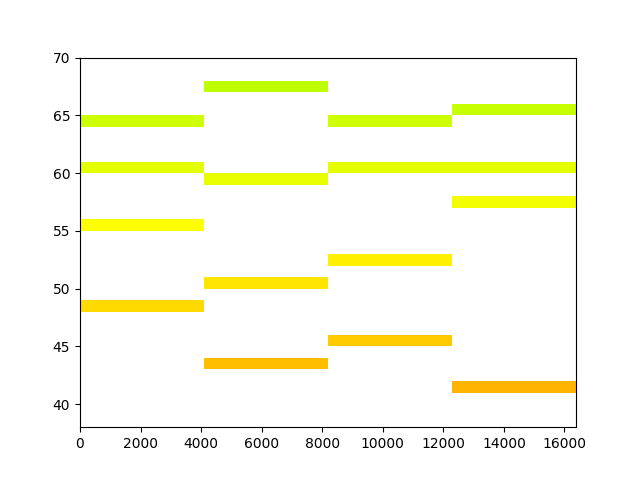

In [29]:


def plot_music(scheduled_style_df: pd.DataFrame, ax=None, cmap=plt.get_cmap("gist_rainbow")):
    if ax is None:
        _, ax = plt.subplots()

    for i, x in scheduled_style_df.iterrows():
        rect = patches.Rectangle((x.time, x.note), width=x.time_duration, height=1, linewidth=0, facecolor=cmap(x.note))
        ax.add_patch(rect)
    plt.xlim(0, scheduled_style_df.time_release.max())
    plt.ylim(scheduled_style_df.note.min() - 3, scheduled_style_df.note.max() + 3)
        

plot_music(pd_track)

